# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the bootstrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [2]:
import numpy as np
import pandas as pd
from scipy import stats # for t-test
from statsmodels.stats import weightstats as ws # for z-test
import matplotlib.pyplot as plt

df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


### 1) Is the distribution of body temperatures normal?

First let's take a look at the ECDF of the temperature data.

In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

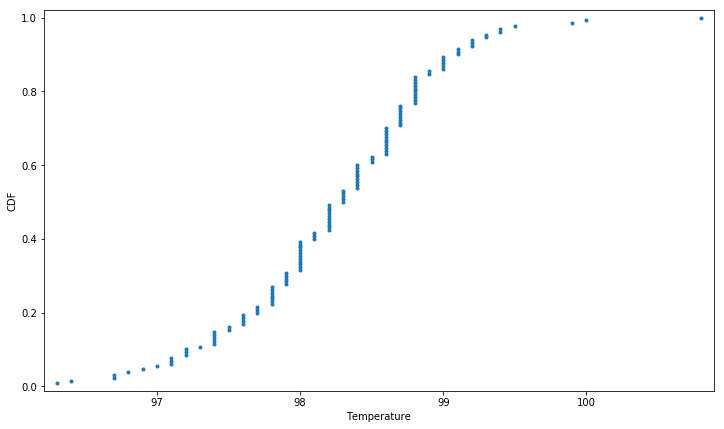

In [3]:
# Create an ECDF from real data: x, y
x, y = ecdf(df['temperature'])
plt.figure(figsize=(12, 7))
plt.plot(x, y, marker='.', linestyle='none')

# Margins and axis labels
plt.margins(0.02)
plt.xlabel('Temperature')
plt.ylabel('CDF')
# Show the plot
plt.show()

At first glance it does appear to take on a normal distribution. However, let's investigate further with a few univariate normality tests using the null hypothesis that our 1D data IS sampled from a normally distributed population. For these tests we will be using a significance level of 0.05, so if our p-value is below this number we can reject the null hypothesis and concluded that the data does not follow a normal distribution.

First let's apply the Kolmogorov–Smirnov test, to see if a normal sample distribution fits the cumulative distribution function (CDF) of the temperature data. Essentially, we are testing the temperature data against a normally distributed sample data with same mean and standard deviation, to compare their distributions for similarities.

In [4]:
df['temperature'].describe()

count    130.000000
mean      98.249231
std        0.733183
min       96.300000
25%       97.800000
50%       98.300000
75%       98.700000
max      100.800000
Name: temperature, dtype: float64

In [5]:
# compare temp data to normal sample distribution with mean of 98.249231 and standard deviation of 0.733183
ks_results = stats.kstest(df['temperature'], cdf='norm', args=(98.249231, 0.733183))

print('Kolmogorov–Smirnov p-value = {:.3f}'.format(ks_results[1]))


Kolmogorov–Smirnov p-value = 0.645


Since the p-value is well above the 0.05 significance level, we cannot reject the null hypothesis. Let's now plot the temperature data against our theoretical normally distributed sample with the same mean and standard deviation as the temperature data to see how they compare graphically.

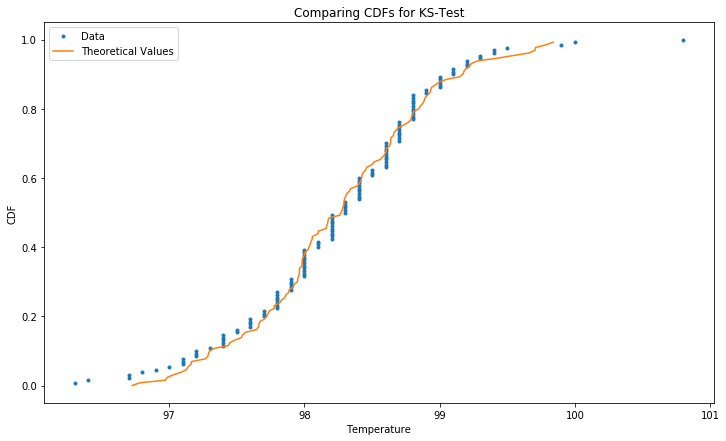

In [6]:
def ks_plot_norm(data):
    length = len(data)
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, marker='.', linestyle='none')
    x_thry = np.sort(stats.norm.rvs(loc=98.249231, scale=0.733183, size=130))
    y_thry = np.linspace(0, 1, len(df['temperature']), endpoint=False)
    plt.plot(x_thry, y_thry)
    plt.legend('top right')
    plt.legend(['Data', 'Theoretical Values'])
    plt.title('Comparing CDFs for KS-Test')
    plt.xlabel('Temperature')
    plt.ylabel('CDF')
    
ks_plot_norm(df['temperature'])

Now let's try the Anderson-Darling test which is derived from Kolmogorov-Smirnov test and is used in a similar way to assesses whether a sample comes from a specified distribution.

In [7]:
anderson_results = stats.anderson(df['temperature'], dist='norm')
print('Anderson-Darling p-value = {:.3f}'.format(anderson_results[1][2]))

Anderson-Darling p-value = 0.765


Lastly, let's try a combination of the D'Agostino and Pearson tests which combines skew and kurtosis to produce an omnibus test of normality.

In [8]:
dagostino_results = stats.normaltest(df['temperature'])
print("D'Agostino and Pearson p-value = {:.3f}".format(dagostino_results[1]))

D'Agostino and Pearson p-value = 0.259


As shown, all the p-values for these tests are well above the 0.05 significance level, so we cannot reasonably reject the null hypothesis.

### 2) Is the sample size large? Are the observations independent?

In [9]:
n = len(df['temperature']) # sample size
print('Sample size, N = {}'.format(n))

Sample size, N = 130


Since N > 30, it is considered a large sample size. In addition, since the measurement of one persons temperature is not affect by the temperature of another the observations are independent.

### 3) Is the true population mean really 98.6 degrees F?

Since we're comparing the mean of temperature dataset to one value, the population mean all of the following tests will be one sample tests. First let's do a One-Sample Bootstrap Hypothesis Test where our test statistic will be the population mean of 98.6 degrees F, and our null hypothesis is that the true population mean of the data is equal to 98.6 degrees F.

In [10]:
def bs_rep_1d(data, func):
    '''Generates bootstrap replicate of 1D data.'''
    bs_sample = np.random.choice(data, size=len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    '''Generates 1d array of bootstrap replicates of length n.'''
    bs_reps = np.empty(size)
    for i in range(size):
        bs_reps[i] = bs_rep_1d(data, func)
    return bs_reps

In [11]:
# first translate the temperature data such that the mean is 98.6 degrees F
trans_temp = df['temperature'] - np.mean(df['temperature']) + 98.6
bs_reps = draw_bs_reps(trans_temp, np.mean, size=10000)
pvalue = np.sum(bs_reps <= np.mean(df['temperature']))/10000
print('Bootstrap hypothesis test p-value: {:.3f}'.format(pvalue))

Bootstrap hypothesis test p-value: 0.000


Now we'll try a one-sample frequentist statistical t-test.

In [12]:
true_mu = 98.6

onesample_results = stats.ttest_1samp(df['temperature'], true_mu)

pvalue = onesample_results[1]
print('t-test p-value: {:.3f}'.format(pvalue))

t-test p-value: 0.000


and lastly, a one-sample frequentist statistical z-test.

In [13]:
pvalue = ws.ztest(df['temperature'])[1]
print('z-test p-value: {:.3f}'.format(pvalue))

z-test p-value: 0.000


Since the p-value is less than 0.05 for all tests, we can reject the null hypothesis and the true population mean is NOT equal to the mean of 98.6 degrees F.

### 4) Draw a small sample of size 10 from the data and repeat both frequentist tests.

First let's try the t-test:

In [14]:
samp = df['temperature'].sample(n=10, random_state=1)

onesample_results = stats.ttest_1samp(samp, true_mu)

pvalue = onesample_results[1]
print('small sample t-test p-value: {:.3f}'.format(pvalue))

small sample t-test p-value: 0.081


z-test:

In [15]:
pvalue = ws.ztest(samp,)[1]
print('small sample z-test p-value: {:.3f}'.format(pvalue))

small sample z-test p-value: 0.000


Here we see that for a sample size of 10, the t-test shows that we cannot reject the null hypothesis, while the z-test shows that we can reject the null hypothesis and that the means are NOT equal. For this reason, it's important to note that for a small sample test the z-test may not perform well if the standard deviation of the small sample size is not reasonably accurate of the actual standard deviation, in which therefore the t-test would be a better test for sample size n < 30.

### 5) At what temperature should we consider someone's temperature to be "abnormal"?

* As in the previous example, try calculating everything using the bootstrap approach, as well as the frequentist approach.
* Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

In [16]:
bs_reps = draw_bs_reps(df['temperature'], np.mean, 10000)
conf_int = np.percentile(bs_reps, [2.5, 97.5])
bs_moe = (conf_int[1] - conf_int[0]) / 2
print('95% CI: [{:.1f}, {:.1f}]'.format(conf_int[0],conf_int[1]))
print('Margin of Error: {:.1f}'.format(bs_moe))

95% CI: [98.1, 98.4]
Margin of Error: 0.1


In [17]:
# frequentist approach : margin of error = SE*CV
se = np.std(df['temperature'])/np.sqrt(len(df['temperature']))
moe = se*1.645
print('Margin of Error: {:.1f}'.format(moe))
f_conf_int = (np.mean(df['temperature']) - moe, np.mean(df['temperature']) + moe)
print('95% CI: [{:.1f}, {:.1f}]'.format(conf_int[0],conf_int[1]))

Margin of Error: 0.1
95% CI: [98.1, 98.4]


From both approaches we see that any temperature below 98.1 and above 98.4 degrees F would have a probability of less than 5% of occurring.

### 6) Is there a significant difference between males and females in normal temperature?

In [3]:
females = df[df['gender']=='F']['temperature']
males = df[df['gender']=='M']['temperature']

In [4]:
np.round(np.mean(females),1)

98.4

In [5]:
np.round(np.mean(males),1)

98.1

Let's do a two sample z-test where our null hypothesis is that both males and females have the same mean temperature.

In [7]:
pvalue = ws.ztest(x1=females,x2=males)[1]
print('z-test p-value: {:.3f}'.format(pvalue))

z-test p-value: 0.022


Based off this p-value of 0.022 we can reject the null hypothesis, which means that males and females do not have the same mean temperature.